Install all the required libraries

In [4]:
%pip install dynamodb-json
%pip install xgboost
%pip install NanoPlot --upgrade

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
Import all the required libraries

import boto3
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from matplotlib import pyplot as plt
from dynamodb_json import json_util as json
from boto3.dynamodb.conditions import Key, Attr

In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xg 
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import plotly.express as px

Connect to DynamoDB  

In [ ]:
dynamodb = boto3.resource('dynamodb')
table = dynamodb.Table('sensorData-dev')
response = table.scan()

Fetch all the values from the table and save it as dataframe

In [8]:
data = pd.DataFrame(json.loads(response["Items"]))
data.head()

,moisture,humidity,node,time,temperature
0,306,68,node1,Tue Nov 29 01:29:54 2022\n,22.200001
1,646,71,node1,Mon Nov 28 21:37:19 2022\n,22.200001
2,294,65,node1,Tue Nov 29 20:51:24 2022\n,21.000000
3,339,64,node1,Tue Nov 29 02:54:30 2022\n,23.000000
4,295,69,node1,Tue Nov 29 08:44:57 2022\n,21.400000


Get all the information to check if all the values are retrieved 

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   moisture     203 non-null    int64  
 1   humidity     203 non-null    int64  
 2   node         203 non-null    object 
 3   time         203 non-null    object 
 4   temperature  203 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 8.1+ KB


In [10]:
data.isna().sum()

moisture       0
humidity       0
node           0
time           0
temperature    0
dtype: int64

Regression

In [11]:
data_reg = data

In [12]:
data_reg['health'] = 0

In [13]:
data_reg.head()

,moisture,humidity,node,time,temperature,health
0,306,68,node1,Tue Nov 29 01:29:54 2022\n,22.200001,0
1,646,71,node1,Mon Nov 28 21:37:19 2022\n,22.200001,0
2,294,65,node1,Tue Nov 29 20:51:24 2022\n,21.000000,0
3,339,64,node1,Tue Nov 29 02:54:30 2022\n,23.000000,0
4,295,69,node1,Tue Nov 29 08:44:57 2022\n,21.400000,0


<AxesSubplot:>

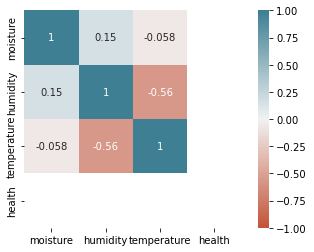

In [14]:
corr=data_reg.corr()
sns.heatmap(corr,vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot = True
)

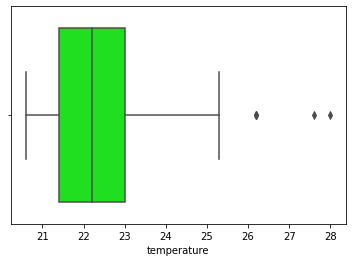

In [15]:
sns.boxplot(x="temperature",data=data_reg,color ="lime");

<AxesSubplot:xlabel='temperature', ylabel='Count'>

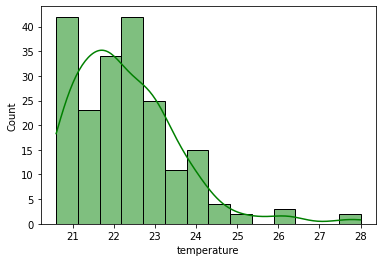

In [17]:
sns.histplot(data_reg.temperature, kde=True,color = "green")

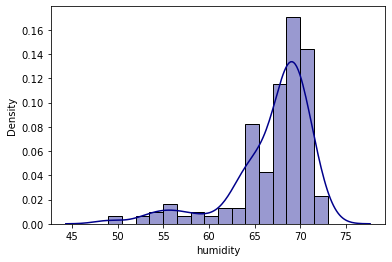

In [18]:
sns.histplot(data_reg.humidity, kde=True,color = "darkblue",alpha=.4, stat="density", kde_kws=dict(cut=3));

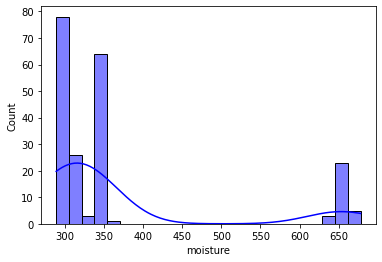

In [19]:
sns.histplot(data_reg.moisture, kde=True,color = "blue");

In [20]:
n,d = data_reg[['temperature', 'moisture', 'humidity']].shape
print("n = ", n)
print("d = ", d)

n =  203
d =  3


Health of a plant is determined using below calculation.

In [22]:
data_reg["health"] = np.where((data_reg["temperature"]>23.0) & (data_reg["moisture"]>300.0) & (data_reg["humidity"]>59), 1, 0).astype(int)
data_reg

,moisture,humidity,node,time,temperature,health
0,306,68,node1,Tue Nov 29 01:29:54 2022\n,22.200001,0
1,646,71,node1,Mon Nov 28 21:37:19 2022\n,22.200001,0
2,294,65,node1,Tue Nov 29 20:51:24 2022\n,21.000000,0
3,339,64,node1,Tue Nov 29 02:54:30 2022\n,23.000000,0
4,295,69,node1,Tue Nov 29 08:44:57 2022\n,21.400000,0
...,...,...,...,...,...,...
198,344,70,node1,Tue Nov 29 05:54:44 2022\n,22.700001,0
199,343,66,node1,Tue Nov 29 04:14:35 2022\n,23.400000,1
200,289,67,node1,Tue Nov 29 19:51:20 2022\n,21.799999,0
201,294,66,node1,Tue Nov 29 20:56:24 2022\n,21.000000,0


In [23]:
X = data_reg[['temperature','moisture','humidity']]
y = data_reg[['health']]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=0)

In [25]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(152, 3)
(152, 1)
(51, 3)
(51, 1)


In [27]:
names = ["MLP", "Nearest Neighbors", "GradientBoostingRegressor","Decision Tree", "AdaBoost","Random Forest", "Linear SVR"]

regressors = [
    MLPRegressor(alpha=1, max_iter=1500),
    KNeighborsRegressor(2),
    GradientBoostingRegressor(n_estimators = 1000, learning_rate = 0.01, max_depth = 5, random_state= 42),
    DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0),
    AdaBoostRegressor(base_estimator=None, n_estimators=50, learning_rate=1.0, loss='linear', random_state=None),
    RandomForestRegressor(max_depth=5, n_estimators=10, max_features=1),
    SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=- 1),
    ]

reg_output = pd.DataFrame(columns=['regressor','mae', 'mse', 'Rsquared', 'accuracy', 'Training time'])

In [28]:
max_score = 0.0
max_class = ''

for name, clf in zip(names, regressors):
    clf.fit(X_train, y_train)
    start_time = time()
    time_finish = time() - start_time
    score = 100.0 * clf.score(X_test, y_test)
    y_preds_reg = clf.predict(X_test)

    
    mae = np.round(metrics.mean_absolute_error(y_test, y_preds_reg), 2)
    mse = np.round(metrics.mean_squared_error(y_test, y_preds_reg), 2)
    rsquared = np.round(metrics.r2_score(y_test, y_preds_reg), 2)
    reg_output = reg_output.append({'regressor': name, 'mae':mae, 'mse':mse,'Rsquared':rsquared, 'accuracy':score, 'Training time':time_finish}, ignore_index=True)
    print('Regression = %s, Score (accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds,'%(time() - start_time))
    if score > max_score:
        clf_best = clf
        max_score = score
        max_class = name
print(80*'-' )
print('Best --> Regression = %s, Score (accuracy) = %.2f' %(max_class, max_score),'Training time = %.2f seconds,'%(time() - start_time))

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Regression = MLP, Score (accuracy) = -24908.72, Training time = 0.02 seconds,
Regression = Nearest Neighbors, Score (accuracy) = 62.22, Training time = 0.03 seconds,
Regression = GradientBoostingRegressor, Score (accuracy) = 86.72, Training time = 0.01 seconds,
Regression = Decision Tree, Score (accuracy) = 100.00, Training time = 0.02 seconds,
Regression = AdaBoost, Score (accuracy) = 43.33, Training time = 0.01 seconds,
Regression = Random Forest, Score (accuracy) = 68.08, Training time = 0.01 seconds,
Regression = Linear SVR, Score (accuracy) = -0.06, Training time = 0.01 seconds,
--------------------------------------------------------------------------------
Best --> Regression = Decision Tree, Score (accuracy) = 100.00 Training time = 0.01 seconds,


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/tmp/ipykernel_13265/3339353620.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exa

Mean Absolute Error (MAE) and Mean squared error (MSE) is also calculated along with accuracy and time taken to train.

In [29]:
display(reg_output)

,regressor,mae,mse,Rsquared,accuracy,Training time
0,MLP,5.02,25.96,-249.09,-24908.716838,1.907349e-06
1,Nearest Neighbors,0.06,0.04,0.62,62.222222,1.430511e-06
2,GradientBoostingRegressor,0.03,0.01,0.87,86.717802,1.192093e-06
3,Decision Tree,0.00,0.00,1.00,100.000000,7.152557e-07
4,AdaBoost,0.06,0.06,0.43,43.333333,9.536743e-07
5,Random Forest,0.06,0.03,0.68,68.077778,9.536743e-07
6,Linear SVR,0.19,0.10,-0.00,-0.063823,7.152557e-07


Classification

In [30]:
data_classify = data

In [31]:
data_classify["health"] = np.where((data_classify["temperature"]>23.0) & (data_classify["moisture"]>300.0) & (data_classify["humidity"]>59), 1, 0).astype(int)
data_classify

,moisture,humidity,node,time,temperature,health
0,306,68,node1,Tue Nov 29 01:29:54 2022\n,22.200001,0
1,646,71,node1,Mon Nov 28 21:37:19 2022\n,22.200001,0
2,294,65,node1,Tue Nov 29 20:51:24 2022\n,21.000000,0
3,339,64,node1,Tue Nov 29 02:54:30 2022\n,23.000000,0
4,295,69,node1,Tue Nov 29 08:44:57 2022\n,21.400000,0
...,...,...,...,...,...,...
198,344,70,node1,Tue Nov 29 05:54:44 2022\n,22.700001,0
199,343,66,node1,Tue Nov 29 04:14:35 2022\n,23.400000,1
200,289,67,node1,Tue Nov 29 19:51:20 2022\n,21.799999,0
201,294,66,node1,Tue Nov 29 20:56:24 2022\n,21.000000,0


In [32]:
X_classify = data_classify[['temperature', 'moisture','humidity']]
y_classify = data_classify[['health']]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_classify, y_classify, test_size=0.3)

In [34]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(142, 3)
(142, 1)
(61, 3)
(61, 1)


In [36]:
names = ["Nearest Neighbors", "Decision Tree", "Random Forest", "XGBoost","Linear Regression"]
classifiers = [
    KNeighborsClassifier(2),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    #MLPClassifier(alpha=1, max_iter=1000),
    xg.XGBRegressor(objective ='reg:linear', silent = True, n_estimators = 10, seed = 123),
    LinearRegression()]

class_output = pd.DataFrame(columns=['classifier','accuracy', 'Training time'])

In [37]:
max_score = 0.0
max_class = ''
    
    # Iterate over classifiers
for name, clf in zip(names, classifiers):
        start_time = time()
        clf.fit(X_train, y_train)
        score = 100.0 * clf.score(X_test, y_test)
        print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time() - start_time))
        y_preds = clf.predict(X_test)
        f1 = np.round(metrics.f1_score(y_test, y_preds.round(), average='weighted'), 2)
        class_output = class_output.append({'classifier': name, 'F1 score':f1, 'accuracy':score, 'Training time':(time() - start_time)}, ignore_index=True)

       
        if score > max_score:
            clf_best = clf
            max_score = score
            max_class = name

print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/tmp/ipykernel_13265/2393291014.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


Classifier = Nearest Neighbors, Score (test, accuracy) = 93.44, Training time = 0.02 seconds
Classifier = Decision Tree, Score (test, accuracy) = 98.36, Training time = 0.01 seconds
Classifier = Random Forest, Score (test, accuracy) = 95.08, Training time = 0.03 seconds
[21:17:22] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:22] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

Classifier = XGBoost, Score (test, accuracy) = 84.19, Training time = 0.21 seconds
Classifier = Linear Regression, Score (test, accuracy) = 7.97, Training time = 0.01 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Decision Tree, Score (test, accuracy) = 98.36


In [38]:
display(class_output)

,classifier,accuracy,Training time,F1 score
0,Nearest Neighbors,93.442623,0.038258,0.93
1,Decision Tree,98.360656,0.017653,0.98
2,Random Forest,95.081967,0.037309,0.94
3,XGBoost,84.186239,0.216100,0.98
4,Linear Regression,7.971280,0.008587,0.81
